In [ ]:
import pandas as pd
import numpy as np
import json
import networkx as nx
from networkx.algorithms import approximation as approx
from itertools import combinations
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import xgboost
import lightgbm as lgbm
from itertools import groupby
from collections import defaultdict as dd

import seaborn as sns



from scipy.stats import uniform
from scipy.stats import randint as sp_randint

from sklearn import metrics, model_selection, pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#%matplotlib inline

In [ ]:
matplotlib.use("TkAgg")
%matplotlib inline

## 1. Data input and graph creation

### 1.1 load all data sets 

In [ ]:
# read nodes.json
nodes_df = pd.read_json('nodes.json')
# fill all na with 0
nodes_df.fillna(0,inplace=True)
# set 'id' as index
nodes_df= nodes_df.set_index("id")

In [ ]:
nodes_df[:5]

In [ ]:
dev_labels_df = pd.read_csv('dev-labels.csv')

In [ ]:
random.seed(30)

In [ ]:
dev_df = pd.read_csv('dev.csv')

In [ ]:
dev_full_df = pd.concat([dev_df.iloc[:,1:3], dev_labels_df['Expected']], axis=1)
dev_full_df[:10]

### 1.2 graph creation and negative sampling

In [9]:

network_graph = open("train.txt","r")
network_graph = network_graph.readlines()
node_1 = []
node_2 = []

for i in network_graph:
    line = i.rstrip("\n").split(" ")
    source,edges = line
    edges = edges.split("\t")
    #G.add_node(int(source))
    for sink in edges:
        node_1.append(source)
        node_2.append(sink)
        #print(source)
        #G.add_edge(int(source),int(sink))

In [11]:
full_edge_list = pd.DataFrame({'Source': node_1, 'Sink': node_2})

In [12]:
y = np.ones(len(full_edge_list))
X_base_edges, X_train_edges, y_base_edges, y_train_edges = train_test_split(full_edge_list, y, test_size=0.10)
print(len(full_edge_list))
print(len(X_base_edges))
print(len(y_base_edges))
print(len(X_train_edges))
print(len(y_train_edges))

47702
42931
42931
4771
4771


In [13]:
# graph created for train data
# this graph will be used for calculating relevant features
G = nx.Graph()
for i in nodes_df.index:
    node = i
    G.add_node(int(node))

In [14]:
for i in X_base_edges.iloc[:,0:2].values:
 
    G.add_edge(int(i[0]),int(i[1]))

In [15]:
dev_node_nega = set()

for i in dev_full_df[dev_full_df['Expected']==-1][['Source','Sink']].values:
    dev_node_nega.add(i[0])
    dev_node_nega.add(i[1])

In [16]:
G_degree = G.degree

In [17]:
# dev_full_df: dev set
# calculate degree for negative and positive edges in dev set
# edges: degree calculation

nega_dev_degree = {}
for i in dev_full_df[dev_full_df['Expected']==-1][['Source','Sink']].values:
    cal = (G.degree[i[0]]+1)*(G.degree[i[1]]+1)
    nega_dev_degree[tuple(i)]=cal
    
    
# in dev set, the number occour of degree of edge
# degree of edge: time in dev set
nega_dev_dist = {}
for v in nega_dev_degree.values():
    if v in nega_dev_dist.keys():
        nega_dev_dist[v] +=1
    else:
        nega_dev_dist[v] = 1
        
        
pos_dev_degree = {}
for i in dev_full_df[dev_full_df['Expected']==1][['Source','Sink']].values:
    cal = (G.degree[i[0]]+1)*(G.degree[i[1]]+1)
    pos_dev_degree[tuple(i)]=cal
    
    
# in dev set, the number occour of degree of edge
# degree of edge: time in dev set
pos_dev_dist = {}
for v in pos_dev_degree.values():
    if v in pos_dev_dist.keys():
        pos_dev_dist[v] +=1
    else:
        pos_dev_dist[v] = 1

In [21]:
# calculate how many edges for each degree calculated number for training (= positive training set)
# degree of edge: number we need
# total edges we will sample;23928.0, inccreased a bit, due to the round function
nega_sample_f ={}
for k,v in nega_dev_dist.items():
    nega_sample_f[k] = int(round(v*len(X_train_edges)/2433,0))

In [22]:
# how many edges we will sample 
sum(nega_sample_f.values())

4820

In [23]:
plt.rcParams['figure.figsize']=[18,6]

In [24]:
# make combination for potential  negative edges
comb = combinations(G.nodes(),2)
missing_edges = set()

for i in comb:
    if i not in G.edges:
        missing_edges.add(i)

In [25]:
len(missing_edges) 

7692965

In [26]:
#potential edges : degree calculation
nega_pool_degree = {}
for i in missing_edges:
    cal = (G.degree[i[0]]+1)*(G.degree[i[1]]+1)
    nega_pool_degree[i]=cal
#nega_pool_dist: 
#degree of edge: number we have
nega_pool_dist = {}
for v in nega_pool_degree.values():
    if v in nega_pool_dist.keys():
        nega_pool_dist[v] +=1
    else:
        nega_pool_dist[v] = 1

In [27]:
# degree of edge: [inculded edges in (source,sink)]
nega_sample_full={}
for k,v in nega_pool_degree.items():
    if v in nega_sample_full.keys():
        nega_sample_full[v] += [k]
    else:
        nega_sample_full[v] = [k]

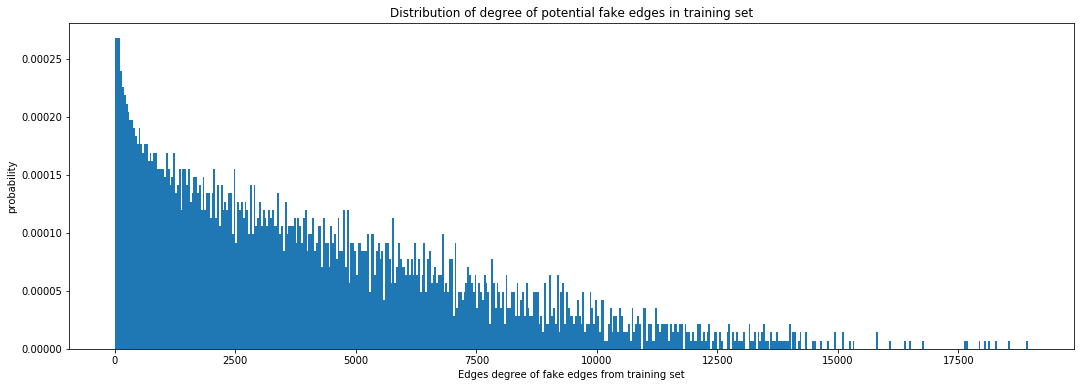

In [28]:
plt.hist(nega_pool_dist.keys(), density=True, bins=500)
plt.title("Distribution of degree of potential fake edges in training set")
plt.xlabel('Edges degree of fake edges from training set')
plt.ylabel('probability')
plt.savefig('Fake_training.png')

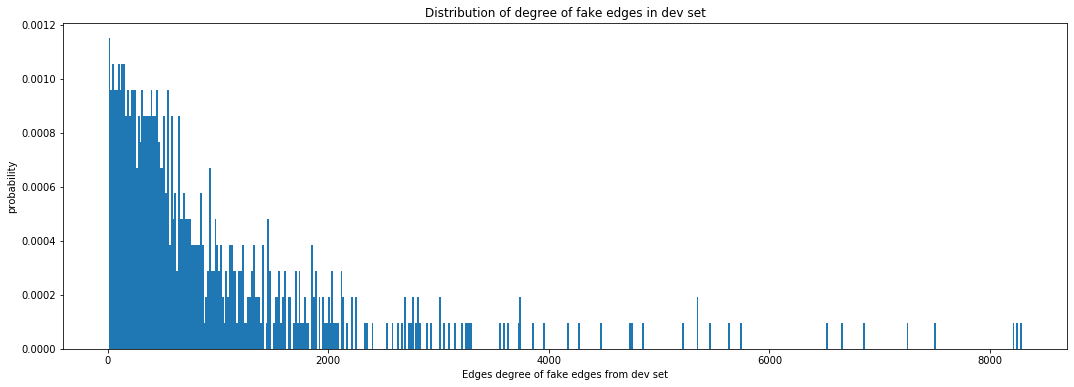

In [29]:
plt.hist(nega_sample_f.keys(),  density=True, bins=500)
plt.title("Distribution of degree of fake edges in dev set")
plt.xlabel('Edges degree of fake edges from dev set')
plt.ylabel('probability')
plt.savefig('Fake_dev.png')

In [30]:
def split_bins_bynum(data, bin_size):
    """Splits a given dataset into bins
    
    input: data: a dictionary with val:volume
    bin_size: the value for the number (int >=1) or percentage (between 0 and 1, integer divisor of 1)
    output: dictionary with (lower bound, bin_upper_bound):total_in_bin"""
    top_degree = max(data.keys())
    num_bins = top_degree//bin_size + 1 if (top_degree % bin_size)>0 else 0
    bin_dict = dd(int)
    for k,v in data.items():
        bin_dict[((k // bin_size)*bin_size,(k // bin_size + 1)*bin_size)] += v
    return bin_dict


In [31]:
ne_sample_need = split_bins_bynum(nega_sample_f, 500)
#pos_sample_need = split_bins_bynum(pos_dev_dist, 500)

In [32]:
ne_sample_need

defaultdict(int,
            {(0, 500): 3846,
             (1000, 1500): 200,
             (500, 1000): 508,
             (2500, 3000): 34,
             (3500, 4000): 16,
             (3000, 3500): 24,
             (1500, 2000): 104,
             (6500, 7000): 6,
             (2000, 2500): 48,
             (4500, 5000): 6,
             (7000, 7500): 2,
             (5500, 6000): 4,
             (8000, 8500): 6,
             (5000, 5500): 8,
             (4000, 4500): 6,
             (7500, 8000): 2})

In [33]:
def split_edges_bybinnum(data, bin_size):
    """Splits a given dataset into bins
    
    input: data: a dictionary with edgeval:tuple
    bin_size: the value for the number (int >=1)
    output: dictionary with (lower bound, bin_upper_bound):total_in_bin"""
    top_degree = max(data.keys())
    num_bins = top_degree//bin_size + 1 if (top_degree % bin_size)>0 else 0
    bin_dict = {}
    for i in range(num_bins):
        bin_dict[((i)*bin_size,(i + 1)*bin_size)] = []
    for k,v in data.items():
        bin_dict[((k // bin_size)*bin_size,(k // bin_size + 1)*bin_size)] += v
    return bin_dict

ne_sample_edges = split_edges_bybinnum(nega_sample_full, 500)

In [34]:
len(ne_sample_edges.values())

38

In [35]:
# sampling 
full_nega_list = []
for k,v in ne_sample_need.items():
    #if k in nega_sample_full.keys() and len(nega_sample_full[k])>=v:
    list_inner = random.sample(ne_sample_edges[k],v)
    full_nega_list +=list_inner   

In [36]:
len(full_nega_list)

4820

## 2. Helper functions

   ### Part. A features generation functions

In [37]:
def public_time(input_node):
    """
    Returns the first and the last year a node who publish an essay.

    input: node number
    output: (first_time, last_time)
    """
    start = 2017 - nodes_df[nodes_df.index == input_node]['first'].values[0]
    finish = 2017 - nodes_df[nodes_df.index == input_node]['last'].values[0]
    
    return (start,finish)

In [38]:
def overlap_year(source_node,sink_node):
    """
    Returns the overlap years between
    source and sink node.

    input: node numbers
    output: [year1,year2,...]
    """
    source_node_year = public_time(source_node)
    sink_node_year = public_time(sink_node)
    
    z=range(max(source_node_year[0], sink_node_year[0]), min(source_node_year[1], sink_node_year[1])+1)
    
    return list(z)

In [39]:
def keyword_find (input_node):
    """
    Returns the keywords appear in the input node.

    input: node number
    output: {keyword01,keyword02,...}
    """   
    set_keyword= set()
    for i in set(nodes_df.iloc[:,1:54]):
        if nodes_df[nodes_df.index == input_node].iloc[:,1:54][i][input_node]>0:
            set_keyword.add(i)
    
    return set_keyword

In [40]:
def venue_find(input_node):
    """
    Returns the venue appear in the input node.

    input: node number
    output: {venue01,venue02,...}
    """  
    #list_venue = []
    set_venue = set()
    for i in set(nodes_df.iloc[:,56:]):
        if nodes_df[nodes_df.index == input_node].iloc[:,56:][i][input_node]>0:
            set_venue.add(i)
    
    return set_venue

In [41]:
def inter_node(source_node,sink_node,para):
    """
    Returns the intersection keyword or venue between source and sink node
    please define with para ('keyword' or 'venue')

    input: two node numbers, one para
    output: {keyword03,keyword07,...} or {venue02, venue09,...} 
    """
    if para == 'keyword':
        list_source =  keyword_find (source_node)
        list_sink =  keyword_find (sink_node)
    elif para == 'venue':
        list_source = venue_find(source_node)
        list_sink = venue_find(sink_node)
    else:
        print('Wrong para input')
        
    return list_source & list_sink  

In [42]:
def cosin_cal (source_node,sink_node,para):
    """
    Returns the cosin similarity between source and sink node
    It can be keyword or venue, please define with para ('keyword' or 'venue')

    input: two node numbers, one para
    output: cosin_similarity
    """
    if para == 'keyword':
        list_source = nodes_df[nodes_df.index == source_node].iloc[:,1:54].values[0]
        list_sink = nodes_df[nodes_df.index == sink_node].iloc[:,1:54].values[0]
    elif para == 'venue':
        list_source = nodes_df[nodes_df.index == source_node].iloc[:,56:].values[0]
        list_sink = nodes_df[nodes_df.index == sink_node].iloc[:,56:].values[0]
    else:
        print('Wrong para input')
  
    cos_result = round(float(cosine_similarity([list_source], [list_sink])), 4)
        
    return cos_result  

In [43]:
def num_paper(source_node,sink_node):
    """
    Returns the sum of papers between source and sink node
    weighted by number of year the node activation

    input: two node numbers
    output: sum_number_paper
    """
    paper_source = nodes_df[nodes_df.index==source_node]['num_papers'].values[0]
    paper_sink = nodes_df[nodes_df.index==sink_node]['num_papers'].values[0]
    
    
    year_source = public_time(source_node)
    year_sink = public_time(sink_node)
    sum_paper = paper_source/(year_source[1]-year_source[0]+1) + paper_sink/(year_sink[1]-year_sink[0]+1)
    
    return sum_paper                                                                       

In [44]:
def node_cal(target_df):
    """
    Returns target df with full set of calculation related with node info,
    include: overlap_year, cosin_num, overlap_keyword & venue, mun_of_paper and etc.

    input: data frame
    output: data frame with all set of calculation
    """
    count = 0

    Overlap_public_time=[]
    Cos_venue=[]
    Cos_keyword=[]
    Inter_venue=[]
    Inter_keyword=[]
    Num_paper =[]

       
    for i in target_df[['Source','Sink']].values:
       
        Overlap_public_time.append(len(overlap_year(i[0],i[1])))
   
        Cos_venue.append(cosin_cal(i[0],i[1],'venue'))
      
        Cos_keyword.append(cosin_cal(i[0],i[1],'keyword'))
   
        venue_comb =  nodes_df.iloc[i[0],56:]*nodes_df.iloc[i[1],56:]
        Inter_venue.append(sum(venue_comb))
  
        keyword_comb =  nodes_df.iloc[i[0],1:54]*nodes_df.iloc[i[1],1:54]
        Inter_keyword.append(sum(keyword_comb))
      
        Num_paper.append(num_paper(i[0],i[1]))
    
        
        # this just for indication
        count +=1
        print(count)

    target_df['Overlap_public_time'] = Overlap_public_time
    target_df['Cos_venue'] = Cos_venue
    target_df['Cos_keyword'] = Cos_keyword
    target_df['Inter_venue'] = Inter_venue
    target_df['Inter_keyword'] = Inter_keyword
    target_df['Num_paper'] = Num_paper

In [45]:
def node_cal_train(target_df):
    """
    Returns target df with full set of calculation related with node info,
    include: overlap_year, cosin_num, mun_of_paper 

    input: data frame
    output: data frame with all set of calculation
    """
    count = 0

    Overlap_public_time=[]
    Cos_venue=[]
    Cos_keyword=[]
    Num_paper =[]
       
    for i in target_df[['Source','Sink']].values:
        Overlap_public_time.append(len(overlap_year(i[0],i[1])))
        Cos_venue.append(cosin_cal(i[0],i[1],'venue'))
        Cos_keyword.append(cosin_cal(i[0],i[1],'keyword'))
        Num_paper.append(num_paper(i[0],i[1]))
        
        # this just for indication
        count +=1
        print(count)

    #target_df['Overlap_paper_time'] = Overlap_public_time
    target_df['Cos_venue'] = Cos_venue
    target_df['Cos_keyword'] = Cos_keyword
    #target_df['Num_paper'] = Num_paper 

In [46]:
def graph_index(G,target_df):
    """
    Returns target df with full set of calculation related with graph info,
    include: 
        jaccard_coe
        resource_allocation
        preferential_attachment
        adamic_adar_index
        common_neighbors
        average_clustering
        shortest_path_length*
        local_node_connectivity
        sum number of degrees
        sum_keyw
        sum_venues
    input: data frame
    output: data frame with all set of calculation
    """
    jc_score=[]
    ra_score=[]
    pa_score=[]
    aa_score=[]
    cn_num=[]
    node_c =[]
    clustering_max = []
    clustering_min = []
    sum_degree = []
    sum_keyw = []
    sum_venue = []


    count = 0
 
    clustering_dict = nx.clustering(G, nodes=None)

    
    keyword_sum =  nodes_df.iloc[:,1:54].sum(axis=1)
    venue_sum = nodes_df.iloc[:,56:].sum(axis=1)
    

    
    for i in target_df[['Source','Sink']].values:
        
      
        
        for u,v,p in nx.jaccard_coefficient(G,[i]):
            jc_score.append(p)
            
        for u,v,p in nx.resource_allocation_index(G,[i]):
            ra_score.append(p)
             
        for u,v,p in nx.preferential_attachment(G,[i]):
            pa_score.append(p)
          
        for u,v,p in nx.adamic_adar_index(G,[i]):
            aa_score.append(p)
           
        cn = len(sorted(nx.common_neighbors(G,i[0],i[1])))
        cn_num.append(cn)
   
        clustering_max.append(max(clustering_dict[i[0]],clustering_dict[i[1]]))
        clustering_min.append(min(clustering_dict[i[0]],clustering_dict[i[1]]))
 
        try:
            nc =  approx.local_node_connectivity(G, i[0], i[1])
            node_c.append(nc)
        except:
            node_c.append(0)
   
            
        count +=1
        #print(count)

        #start = time.time()  
        degrees = nx.degree(G,i[0])+nx.degree(G,i[1])
        sum_degree.append(degrees)
 
        total_keywords = keyword_sum[i[0]] + keyword_sum[i[1]]
        sum_keyw.append(total_keywords)
        
        total_venues = venue_sum[i[0]] + venue_sum[i[1]]
        sum_venue.append(total_venues)
    
    target_df['Jaccard'] = jc_score
    target_df['Resource_allocation'] = ra_score
    target_df['Pre_attachment'] = pa_score
    target_df['Adamic_adar'] = aa_score
    target_df['Com_neighbors'] = cn_num
    target_df['Clustering_min'] = clustering_min
    target_df['Clustering_max'] = clustering_max
    target_df['Node_c'] = node_c
    target_df['Sum_degree'] = sum_degree
    target_df['Sum_keyword'] = sum_keyw
    target_df['Sum_venue'] = sum_venue

  


In [47]:
#Katz centrality
centrality = nx.katz_centrality(G, alpha=0.005,beta=1) #why 0.005? if not set, cannot converage
def katz_central(node):
    return centrality[node]

def katz_central_column(df):
    katz_max = []
    katz_min = []
    num_node = df.shape[0]
    for i in range(num_node):
        node1 = df['Source'][i]
        node2 = df['Sink'][i]
        katz = (katz_central(node1), katz_central(node2))
        katz_sort = sorted(katz)
        katz_min.append(katz_sort[0])
        katz_max.append(katz_sort[1])
    return katz_min, katz_max


# Paper rank measures the importance
paperank = nx.pagerank(G) 
def paperank_value(node):
    return paperank[node]

def paperank_column(df):
    paperank_max = []
    paperank_min = []
    num_node = df.shape[0]
    for i in range(num_node):
        node1 = df['Source'][i]
        node2 = df['Sink'][i]
        paperank = (paperank_value(node1), paperank_value(node2))
        paperank_sort = sorted(paperank)
        paperank_min.append(paperank_sort[0])
        paperank_max.append(paperank_sort[1])
    return paperank_min, paperank_max

In [48]:
# note I have update the function
def extra_feature_1(input_df):
    katz_min, katz_max = katz_central_column(input_df)
    input_df['katz_min'] = katz_min
    input_df['katz_max'] = katz_max
    paperank_min, paperank_max = paperank_column(input_df)
    input_df['paperank_min'] = paperank_min
    input_df['paperank_max'] = paperank_max

   ### Part. B Model fitting and evaluation functions

In [49]:
def CV_predict(estimator, X, y, k):
    feature = np.zeros(len(X))
    kf = KFold(n_splits=k)
    features = []
    for train_index, test_index in kf.split(X, y):
        clf=estimator
        Xtrain, ytrain = X.iloc[train_index], y.iloc[train_index]
        clf.fit(Xtrain, ytrain)
        feature[test_index] = clf.predict(X.iloc[test_index])
        
    feature = feature[:, np.newaxis]
    features.append(feature)
    features = np.concatenate(features, axis=1)
    features = np.concatenate([X, features], axis=1)
    
    
    return pd.DataFrame(features[:,-1])

In [50]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,6))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
   
    plt.show()

## Data combination and features generation

In [51]:
# This is to put positive and negative edges together, i did not change the name of the function


def combine_edges(negative_sample):    
    """
    Returns the a full training set with negative edges sampling following the cosin venue
    
    input: random edges
    output: full training df
    """
    source = []
    sink = []
    expected = []
    
    for i in X_train_edges[['Source','Sink']].values:
        source.append(int(i[0]))
        sink.append(int(i[1]))
        expected.append(1)

    for i in negative_sample:
        source.append(int(i[0]))
        sink.append(int(i[1]))
        expected.append(-1)

    full_train = pd.DataFrame(list(zip(source, sink, expected)), 
               columns =['Source', 'Sink', 'Expected']) 

    return  full_train 


In [52]:
full_train_after = combine_edges(full_nega_list)

In [53]:
full_train_after.head()

,Source,Sink,Expected
0,621,2949,1
1,1327,1677,1
2,2510,264,1
3,2578,1327,1
4,737,3527,1


### Training data preparation 

In [54]:
graph_index(G,full_train_after)
extra_feature_1(full_train_after)
node_cal(full_train_after)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710


5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356


6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000


8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648


## 4. Model training and evaluation

In [55]:
# shuffle the data, not needed
#df = full_train.sample(frac=1)
df = full_train_after.sample(frac=1)
df.head()

,Source,Sink,Expected,Jaccard,Resource_allocation,Pre_attachment,Adamic_adar,Com_neighbors,Clustering_min,Clustering_max,...,katz_min,katz_max,paperank_min,paperank_max,Overlap_public_time,Cos_venue,Cos_keyword,Inter_venue,Inter_keyword,Num_paper
2951,2038,1477,1,0.365672,0.601814,8360,11.071720,49,0.395745,0.477534,...,0.024775,0.025071,0.001110,0.001203,8,0.3430,0.7485,4.0,22.0,5.500000
9233,977,2889,-1,0.009615,0.015385,776,0.239556,1,0.084192,0.428571,...,0.015412,0.023234,0.000185,0.001613,8,0.4564,0.5850,5.0,16.0,13.875000
5270,450,2354,-1,0.000000,0.000000,12,0.000000,0,0.000000,0.348485,...,0.014821,0.015728,0.000261,0.000273,4,0.2357,0.4045,1.0,6.0,2.375000
2706,2583,2516,1,0.062500,0.083333,66,0.402430,1,0.266667,0.836364,...,0.015220,0.015666,0.000162,0.000229,4,0.2887,0.4804,1.0,6.0,1.571429
9293,130,1822,-1,0.000000,0.000000,445,0.000000,0,0.405005,1.000000,...,0.015130,0.024489,0.000185,0.001193,7,0.2182,0.5916,2.0,14.0,4.250000


In [56]:
# training data
Y_train = df.Expected
X_train = df.drop(['Source', 'Sink','Expected'],axis=1)
#X_train =  df[['Jaccard','Resource_allocation', 'Adamic_adar','Com_neighbors']]
#              'Cos_venue','Cos_keyword','Num_paper']].values

## we calculate the features for dev set use base graph

In [57]:
# development data,question, do we need to re-calculate the features here?
graph_index(G,dev_full_df)
extra_feature_1(dev_full_df)
node_cal(dev_full_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706


In [61]:
dev_full_df[:10]

,Source,Sink,Expected,Jaccard,Resource_allocation,Pre_attachment,Adamic_adar,Com_neighbors,Clustering_min,Clustering_max,...,katz_min,katz_max,paperank_min,paperank_max,Overlap_public_time,Cos_venue,Cos_keyword,Inter_venue,Inter_keyword,Num_paper
0,1,3519,-1,0.0,0.0,45,0.0,0,0.388889,0.800000,...,0.015172,0.015674,0.000129,0.000163,3,0.0000,0.4629,0.0,6.0,2.583333
1,3,943,1,0.0,0.0,15,0.0,0,0.333333,0.400000,...,0.014980,0.015157,0.000104,0.000165,3,0.2500,0.5164,1.0,8.0,4.000000
2,3,2971,-1,0.0,0.0,225,0.0,0,0.400000,0.535354,...,0.015157,0.018870,0.000165,0.000621,1,0.2500,0.6516,1.0,11.0,4.066667
3,4,1871,-1,0.0,0.0,90,0.0,0,0.241830,0.800000,...,0.015134,0.016437,0.000197,0.000306,5,0.2828,0.6158,2.0,16.0,3.450000
4,5,893,1,0.0,0.0,8,0.0,0,0.000000,0.142857,...,0.014826,0.015369,0.000057,0.000297,5,0.0000,0.4851,0.0,8.0,2.000000
5,5,1640,1,0.0,0.0,4,0.0,0,0.000000,0.500000,...,0.014826,0.015057,0.000057,0.000165,3,0.0000,0.3667,0.0,4.0,1.916667
6,5,2530,1,0.0,0.0,12,0.0,0,0.000000,0.545455,...,0.014826,0.015772,0.000057,0.000273,3,0.0000,0.5966,0.0,11.0,2.416667
7,5,3199,1,0.0,0.0,4,0.0,0,0.000000,0.500000,...,0.014826,0.015050,0.000057,0.000180,5,0.0000,0.6063,0.0,10.0,1.833333
8,6,1844,-1,0.0,0.0,1071,0.0,0,0.287843,0.395238,...,0.016494,0.019701,0.000424,0.000747,8,0.5303,0.6790,3.0,19.0,4.625000
9,6,2654,-1,0.0,0.0,231,0.0,0,0.395238,0.454545,...,0.015646,0.016494,0.000286,0.000424,8,0.0000,0.5143,0.0,10.0,2.250000


In [62]:
Y_test = dev_full_df.Expected

X_test = dev_full_df.drop(['Source', 'Sink','Expected'],axis=1)
#X_test = dev_full_df[['Jaccard','Resource_allocation', 'Adamic_adar','Com_neighbors']]
#                      'Katz_sink','Katz_source','PageR_sink','PageR_source']]
#                 'Cos_venue','Cos_keyword','Num_paper']].values

In [63]:
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(X_train, Y_train, test_size=0.2, random_state=20)#fill in

## Random forest

Estimators =  5 Train Score 0.9549346912678114 test Score 0.9463768210395512
Estimators =  10 Train Score 0.9610887833394227 test Score 0.9546879955856219
Estimators =  50 Train Score 0.9623980026793327 test Score 0.9588568889931656
Estimators =  75 Train Score 0.9616158963585434 test Score 0.9578108638885628
Estimators =  120 Train Score 0.9610982980148581 test Score 0.9578070621358463
Estimators =  150 Train Score 0.9616158963585434 test Score 0.9583300746881476
Estimators =  200 Train Score 0.9614883997077092 test Score 0.9578070621358463


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

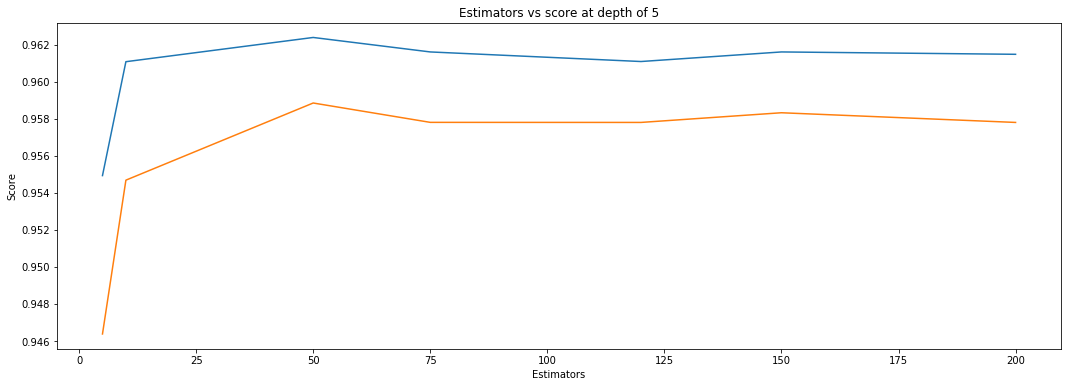

In [64]:
estimators = [5,10,50,75,120,150,200]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_f,Y_train_f)
    train_sc = roc_auc_score(Y_train_f,clf.predict(X_train_f))
    test_sc = roc_auc_score(Y_test_f,clf.predict(X_test_f))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9556559036658142 test Score 0.9510345112249465
depth =  9 Train Score 0.9604436883449032 test Score 0.9567686405366771
depth =  11 Train Score 0.9607005845816587 test Score 0.9562456279843758
depth =  15 Train Score 0.9607005845816587 test Score 0.9562456279843758
depth =  20 Train Score 0.9607005845816587 test Score 0.9562456279843758
depth =  35 Train Score 0.9607005845816587 test Score 0.9562456279843758
depth =  50 Train Score 0.9607005845816587 test Score 0.9562456279843758
depth =  70 Train Score 0.9607005845816587 test Score 0.9562456279843758


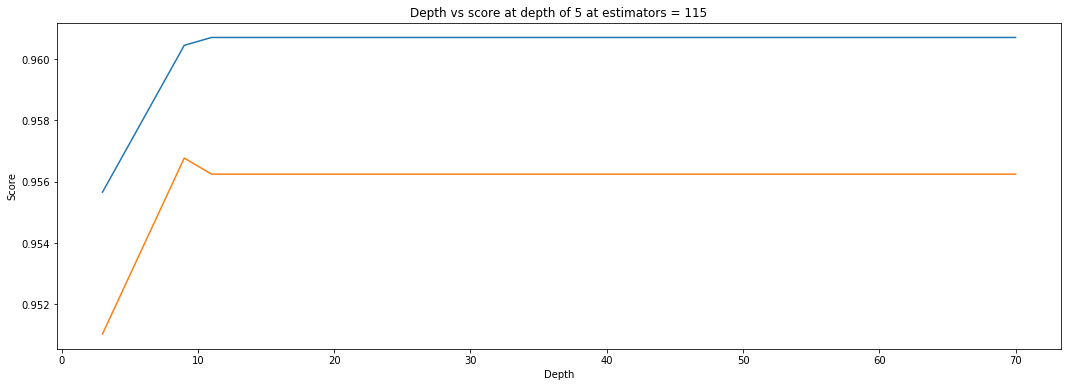

In [65]:
depths = [3,9,11,15,20,35,50,70]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_f,Y_train_f)
    train_sc = roc_auc_score(Y_train_f,clf.predict(X_train_f))
    test_sc = roc_auc_score(Y_test_f,clf.predict(X_test_f))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [66]:

param_dist = {"n_estimators":sp_randint(35,60),
              "max_depth": sp_randint(1,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65),
               }

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='roc_auc',random_state=25,return_train_score=True)

rf_random.fit(X_train_f,Y_train_f)


#rf_random.fit(X_test,Y_test)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.99084542 0.99139187 0.9911078  0.99134359 0.99079192]
mean train scores [0.9925883  0.99370338 0.99295402 0.99340435 0.99285258]


In [67]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=33, min_samples_split=138,
                       min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [68]:
RF = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=33, min_samples_split=138,
                       min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [69]:
RF.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=33, min_samples_split=138,
                       min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [70]:
print(RF.score(X_test_f, Y_test_f))

0.9583116206357478


In [71]:
print(RF.score(X_test, Y_test))

0.6193999177969585


In [72]:
RF_pred_test = RF.predict(X_test)
RF_pred_train = RF.predict(X_train_f)
#RF_pred_upload = RF.predict(X_final)

In [73]:

auc_rf = roc_auc_score(Y_test,  RF.predict_proba(X_test)[:, 1])
auc_rf

0.6988969824929144

In [74]:
count1 = 0
for i in list(RF_pred_test):
    if i == 1:
        count1 +=1

print(count1)

779


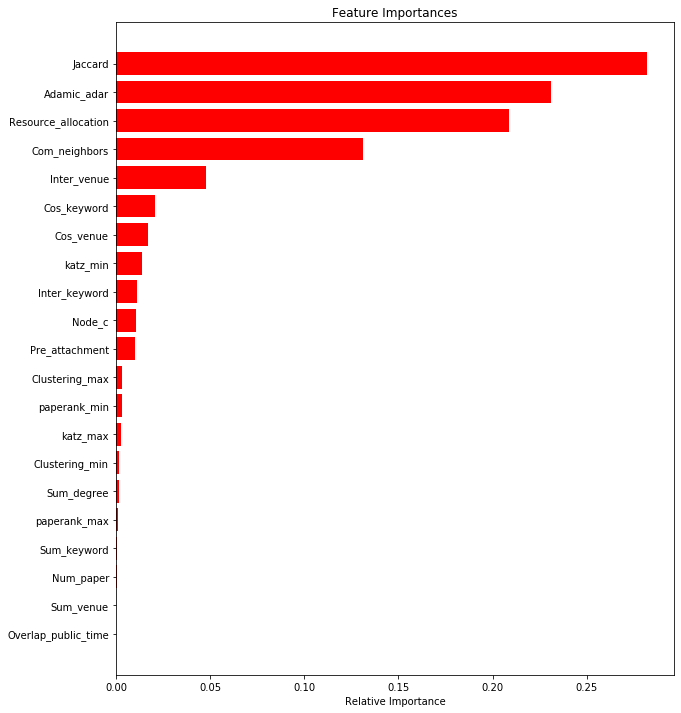

In [75]:
features = X_train_f.columns
importances = RF.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [76]:
from numpy import sort
# Fit model using each importance as a threshold
thresholds = list(sort(RF.feature_importances_))

#must be greater than  1%
thresholds = list(filter(lambda a: a >0, thresholds))
thresholds

[0.00022574084558744017,
 0.00023887238594491017,
 0.0003186998276546505,
 0.00038721380774865927,
 0.0011280328643008127,
 0.0015079613319269574,
 0.0018456245391489502,
 0.002685407877409453,
 0.0029553492116150084,
 0.0033994997089167624,
 0.010156670773103086,
 0.010816852627406035,
 0.011414866497482348,
 0.013724349461535357,
 0.017209916661813717,
 0.020539172730086853,
 0.04775326583171909,
 0.1313319304742253,
 0.20879877234368893,
 0.23131542767679544,
 0.28224637252189005]

In [77]:
for thresh in tqdm(thresholds):
    selection = SelectFromModel(RF, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    #predictions = [round(value) for value in y_pred]
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_score(Y_test, y_pred)*100.0), end =' ')
    #print("f1_score: ", f1_score(y_test,y_pred))

  5%|██                                         | 1/21 [00:00<00:15,  1.31it/s]

Thresh=0.000, n=21, Accuracy: 62.25% 

 10%|████                                       | 2/21 [00:01<00:14,  1.31it/s]

Thresh=0.000, n=20, Accuracy: 62.04% 

 14%|██████▏                                    | 3/21 [00:02<00:13,  1.31it/s]

Thresh=0.000, n=19, Accuracy: 62.35% 

 19%|████████▏                                  | 4/21 [00:03<00:12,  1.31it/s]

Thresh=0.000, n=18, Accuracy: 62.25% 

 24%|██████████▏                                | 5/21 [00:03<00:12,  1.30it/s]

Thresh=0.001, n=17, Accuracy: 62.25% 

 29%|████████████▎                              | 6/21 [00:04<00:11,  1.30it/s]

Thresh=0.002, n=16, Accuracy: 62.23% 

 33%|██████████████▎                            | 7/21 [00:05<00:10,  1.29it/s]

Thresh=0.002, n=15, Accuracy: 62.06% 

 38%|████████████████▍                          | 8/21 [00:06<00:10,  1.29it/s]

Thresh=0.003, n=14, Accuracy: 62.17% 

 43%|██████████████████▍                        | 9/21 [00:06<00:09,  1.30it/s]

Thresh=0.003, n=13, Accuracy: 62.19% 

 48%|████████████████████                      | 10/21 [00:07<00:08,  1.35it/s]

Thresh=0.003, n=12, Accuracy: 62.27% 

 52%|██████████████████████                    | 11/21 [00:08<00:07,  1.39it/s]

Thresh=0.010, n=11, Accuracy: 62.19% 

 57%|████████████████████████                  | 12/21 [00:09<00:06,  1.36it/s]

Thresh=0.011, n=10, Accuracy: 62.17% 

 62%|██████████████████████████                | 13/21 [00:09<00:05,  1.40it/s]

Thresh=0.011, n=9, Accuracy: 62.23% 

 67%|████████████████████████████              | 14/21 [00:10<00:04,  1.43it/s]

Thresh=0.014, n=8, Accuracy: 62.02% 

 71%|██████████████████████████████            | 15/21 [00:11<00:04,  1.46it/s]

Thresh=0.017, n=7, Accuracy: 61.98% 

 76%|████████████████████████████████          | 16/21 [00:11<00:03,  1.47it/s]

Thresh=0.021, n=6, Accuracy: 62.00% 

 81%|██████████████████████████████████        | 17/21 [00:12<00:02,  1.49it/s]

Thresh=0.048, n=5, Accuracy: 62.04% 

 86%|████████████████████████████████████      | 18/21 [00:12<00:02,  1.50it/s]

Thresh=0.131, n=4, Accuracy: 61.94% 

 90%|██████████████████████████████████████    | 19/21 [00:13<00:01,  1.57it/s]

Thresh=0.209, n=3, Accuracy: 61.96% 

 95%|████████████████████████████████████████  | 20/21 [00:14<00:00,  1.63it/s]

Thresh=0.231, n=2, Accuracy: 61.82% 

100%|██████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]

Thresh=0.282, n=1, Accuracy: 61.53% 

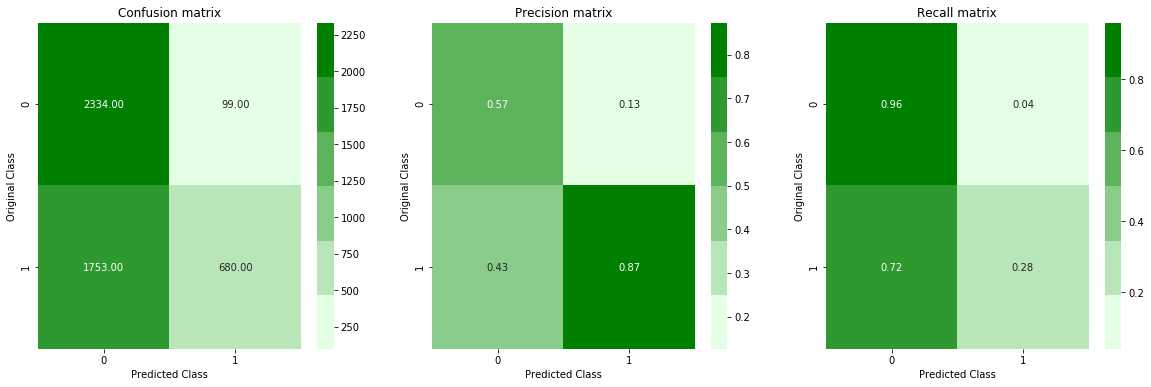

In [79]:
plot_confusion_matrix(Y_test,RF_pred_test)

## XGBboost

In [80]:
params={'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5] }

In [81]:
#Instantiate our Classifier
Classifier = xgboost.XGBClassifier()

In [82]:
random_search = RandomizedSearchCV(Classifier, param_distributions=params, n_iter=10, scoring="roc_auc", 
                                   n_jobs=2, cv=10, verbose=5)

In [83]:
random_search.fit(X_train_f, Y_train_f)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   40.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   54.8s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                  

In [84]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
#from sklearn.linear_model import LogisticRegressionCV as LRCV

XGB = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
XGB.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
XGB_pred_train = CV_predict(XGB, X_train_f,Y_train_f,5)

XGB_pred_test = XGB.predict(X_test_f)

#XGB_pred_upload = RF.predict(X_final)

In [88]:
auc_XGB = roc_auc_score(Y_test,  XGB.predict_proba(X_test)[:, 1])
auc_XGB

0.6981099213124646

In [89]:
print(XGB.score(X_test_f, Y_test_f))

0.9645648775403857


In [90]:
XGB.score(X_train_f, Y_train_f)

0.9706725755995829

In [91]:
XGB.score(X_test, Y_test)

0.6146732429099877

## LR

In [92]:


logistic_model = LogisticRegression(C=1.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logistic_model.fit(X_train, Y_train)

LogisticRegression(C=1.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
#test_preds = logistic_model.predict_proba(test_embedded_edges)[:, 1]
validation_preds = logistic_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, validation_preds)
print(logistic_model.coef_)
print(auc)

[[ 6.15138805e+00  3.60614438e+00 -9.14257788e-04  9.28547641e+00
  -1.22963924e+00 -1.67245435e+00 -1.55762544e+00 -2.60281208e-02
  -2.14435860e-03 -8.54190633e-03  4.66284614e-02 -6.22036878e-02
  -3.94069641e-02 -6.49419173e-03  5.22740783e-03  2.01187894e-02
   4.45670851e+00  6.35654781e+00  7.32830623e-02 -7.48427400e-02
   3.27910967e-02]]
0.685527754169321


In [94]:
LR_pred_test = logistic_model.predict(X_test)

In [95]:
print('accuracy_score=',roc_auc_score(Y_test,LR_pred_test))

accuracy_score= 0.5910398684751337


## lgbm

In [96]:
train_data = lgbm.Dataset(X_train_f, Y_train_f)
test_data = lgbm.Dataset(X_test , Y_test)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'num_leaves': 13,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.66013
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.625674
[3]	valid_0's auc: 0.643616
[4]	valid_0's auc: 0.660635
[5]	valid_0's auc: 0.667339
[6]	valid_0's auc: 0.665558
[7]	valid_0's auc: 0.673776
[8]	valid_0's auc: 0.675658
[9]	valid_0's auc: 0.677507
[10]	valid_0's auc: 0.677828
[11]	valid_0's auc: 0.667716
[12]	valid_0's auc: 0.671767
[13]	valid_0's auc: 0.676247
[14]	valid_0's auc: 0.681106
[15]	valid_0's auc: 0.679101
[16]	valid_0's auc: 0.683386
[17]	valid_0's auc: 0.683321
[18]	valid_0's auc: 0.68669
[19]	valid_0's auc: 0.688382
[20]	valid_0's auc: 0.690592
[21]	valid_0's auc: 0.691959
[22]	valid_0's auc: 0.691362
[23]	valid_0's auc: 0.693569
[24]	valid_0's auc: 0.693487
[25]	valid_0's auc: 0.691867
[26]	valid_0's auc: 0.689451
[27]	valid_0's auc: 0.689012
[28]	valid_0's auc: 0.69073
[29]	valid_0's auc: 0.693912
[30]	valid_0's auc: 0.694686
[31]	valid_0's auc: 0.694554
[32]	valid_0's auc: 0.695796
[33]	valid_0's auc: 0.6

In [97]:
model.save_model('model.txt')

## Final test
### we need to add the positive edges from dev set into the graph, then calculate the featrues for public test data set

In [98]:
centrality = nx.katz_centrality(G, alpha=0.005,beta=1) 
# Paper rank measures the importance
paperank = nx.pagerank(G)

In [99]:
G_new = G.copy()

In [100]:
new_edge=dev_full_df[dev_full_df['Expected']==1][['Source','Sink']].values

In [101]:
G_new.add_edges_from(new_edge)

In [102]:
len(G_new.edges())

26026

In [103]:
# we calculate the test features depended on new graph
test_df = pd.read_csv('test-public.csv')


In [104]:
#test_df

In [105]:
graph_index(G_new,test_df)
extra_feature_1(test_df)
node_cal(test_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


In [106]:
X_final = test_df.drop(['Source', 'Sink','Id'],axis=1)
    #                       'Hub_source','Sum_venue','Num_paper','Max_t','Clustering','Authorities_source','Node_c','Cos_keyword',
     #                  'Overlap_public_time','Inter_venue','Jaccard','Katz_source','PageR_sink','Com_neighbors'],axis=1)

#X_final = test_df[['Jaccard','Resource_allocation', 'Adamic_adar','Com_neighbors']]
                           #'Hub_source','Sum_venue','Num_paper','Max_t','Clustering','Authorities_source','Node_c','Cos_keyword']
#X_final = test_df[['Jaccard','Resource_allocation', 'Min_coe', 'Adamic_adar','Com_neighbors','Node_c','Cos_keyword','Cos_venue',
                      #'Katz_sink','Katz_source','PageR_sink','PageR_source']]

In [107]:
X_final[:5]

,Jaccard,Resource_allocation,Pre_attachment,Adamic_adar,Com_neighbors,Clustering_min,Clustering_max,Node_c,Sum_degree,Sum_keyword,...,katz_min,katz_max,paperank_min,paperank_max,Overlap_public_time,Cos_venue,Cos_keyword,Inter_venue,Inter_keyword,Num_paper
0,0.000000,0.000000,72,0.000000,0,0.199275,0.666667,3,27,30.0,...,0.015045,0.016705,0.000085,0.000425,4,0.0000,0.4472,0.0,5.0,1.625000
1,0.222222,0.152027,30,0.757836,2,0.400000,0.500000,5,11,30.0,...,0.014906,0.015157,0.000078,0.000165,3,0.5000,0.6000,2.0,9.0,4.000000
2,0.000000,0.000000,66,0.000000,0,0.309091,0.400000,5,17,40.0,...,0.015157,0.015665,0.000165,0.000253,3,0.5000,0.7230,3.0,14.0,4.916667
3,0.250000,0.058277,24,0.565477,2,0.400000,0.833333,4,10,24.0,...,0.015007,0.015157,0.000087,0.000165,1,0.3536,0.5164,1.0,6.0,4.666667
4,0.017857,0.015873,702,0.241363,1,0.267974,0.742240,18,57,39.0,...,0.016437,0.018883,0.000306,0.000477,8,0.2582,0.5880,2.0,11.0,3.125000


In [108]:
# build the final train set (train + dev)

In [109]:
X_train_final = pd.concat([X_train,X_test],ignore_index=True)
Y_train_final = pd.concat([Y_train,Y_test],ignore_index=True)

In [110]:
X_train_final[:5]

,Jaccard,Resource_allocation,Pre_attachment,Adamic_adar,Com_neighbors,Clustering_min,Clustering_max,Node_c,Sum_degree,Sum_keyword,...,katz_min,katz_max,paperank_min,paperank_max,Overlap_public_time,Cos_venue,Cos_keyword,Inter_venue,Inter_keyword,Num_paper
0,0.365672,0.601814,8360,11.071720,49,0.395745,0.477534,88,183,59.0,...,0.024775,0.025071,0.001110,0.001203,8,0.3430,0.7485,4.0,22.0,5.500000
1,0.009615,0.015385,776,0.239556,1,0.084192,0.428571,8,105,61.0,...,0.015412,0.023234,0.000185,0.001613,8,0.4564,0.5850,5.0,16.0,13.875000
2,0.000000,0.000000,12,0.000000,0,0.000000,0.348485,0,13,31.0,...,0.014821,0.015728,0.000261,0.000273,4,0.2357,0.4045,1.0,6.0,2.375000
3,0.062500,0.083333,66,0.402430,1,0.266667,0.836364,5,17,25.0,...,0.015220,0.015666,0.000162,0.000229,4,0.2887,0.4804,1.0,6.0,1.571429
4,0.000000,0.000000,445,0.000000,0,0.405005,1.000000,3,94,51.0,...,0.015130,0.024489,0.000185,0.001193,7,0.2182,0.5916,2.0,14.0,4.250000


## LR

In [111]:
logistic_model.fit(X_train_final, Y_train_final)

LogisticRegression(C=1.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
#test_preds = logistic_model.predict_proba(test_embedded_edges)[:, 1]
final_preds = logistic_model.predict_proba(X_final)
#auc = roc_auc_score(Y_test, validation_preds)
#print(logistic_model.coef_)
#print(auc)

In [113]:
list(final_preds)

[array([0.85582266, 0.14417734]),
 array([0.01814916, 0.98185084]),
 array([0.57355003, 0.42644997]),
 array([0.11113103, 0.88886897]),
 array([0.71632424, 0.28367576]),
 array([0.91367396, 0.08632604]),
 array([0.88894445, 0.11105555]),
 array([0.87580758, 0.12419242]),
 array([0.01209877, 0.98790123]),
 array([0.88299264, 0.11700736]),
 array([0.74836329, 0.25163671]),
 array([0.01255638, 0.98744362]),
 array([0.8449146, 0.1550854]),
 array([0.76340119, 0.23659881]),
 array([0.90531117, 0.09468883]),
 array([0.91070754, 0.08929246]),
 array([0.41248883, 0.58751117]),
 array([0.7655034, 0.2344966]),
 array([0.50840688, 0.49159312]),
 array([0.69425343, 0.30574657]),
 array([0.62986505, 0.37013495]),
 array([0.92621594, 0.07378406]),
 array([0.57462949, 0.42537051]),
 array([0.28514503, 0.71485497]),
 array([0.57954276, 0.42045724]),
 array([0.75658869, 0.24341131]),
 array([0.83739482, 0.16260518]),
 array([0.50119459, 0.49880541]),
 array([0.65240054, 0.34759946]),
 array([0.91226485

In [114]:
count_1 = 0
for i in final_preds:
    if i[1]>=0.5:
        count_1 +=1

        print(count_1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Tree

In [116]:
RF.fit(X_train_final, Y_train_final)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=33, min_samples_split=138,
                       min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [117]:
ypred_t_f= RF.predict_proba(X_final)

In [118]:
list(ypred_t_f)

[array([0.84114844, 0.15885156]),
 array([0.00907748, 0.99092252]),
 array([0.73233999, 0.26766001]),
 array([0.01282981, 0.98717019]),
 array([0.67335024, 0.32664976]),
 array([0.88877575, 0.11122425]),
 array([0.89647492, 0.10352508]),
 array([0.82647672, 0.17352328]),
 array([0.02430567, 0.97569433]),
 array([0.89256386, 0.10743614]),
 array([0.81912537, 0.18087463]),
 array([0.01953419, 0.98046581]),
 array([0.9233659, 0.0766341]),
 array([0.77119047, 0.22880953]),
 array([0.9370706, 0.0629294]),
 array([0.91917874, 0.08082126]),
 array([0.34285797, 0.65714203]),
 array([0.77346964, 0.22653036]),
 array([0.74747786, 0.25252214]),
 array([0.70243483, 0.29756517]),
 array([0.7596564, 0.2403436]),
 array([0.85653099, 0.14346901]),
 array([0.74606315, 0.25393685]),
 array([0.33476512, 0.66523488]),
 array([0.48882369, 0.51117631]),
 array([0.80142413, 0.19857587]),
 array([0.89396241, 0.10603759]),
 array([0.64075153, 0.35924847]),
 array([0.71069894, 0.28930106]),
 array([0.93172601, 

In [119]:
print(RF.score(X_test, Y_test))

0.6471434443074394


In [121]:
#lala = []
#for i in list(ypred_t_f):
#    lala.append(i[1])

    
#sub_df =  pd.DataFrame(list(zip(list(test_df['Id'].values), lala)), 
               #columns =['Id','Predicted']) 

#sub_df.to_csv('sub_df_rf_0705_2.csv', index=False)

## lgbm

In [131]:
train_t = lgbm.Dataset(X_train_final, Y_train_final)
#test_t = lgbm.Dataset(X_test_f, Y_test_f)
params={}

#parameters={}
model_f = lgbm.train(parameters,
                   train_t,
                    num_boost_round = 10,
                   init_model='model.txt')

In [132]:
ypred_final=model_f.predict(X_final)

In [133]:
list(ypred_final)

[0.08042346695612382,
 0.9898750036345597,
 0.2826615456645695,
 0.9757517259437618,
 0.11363438329103583,
 0.07261171979522311,
 0.05761337170478248,
 0.06014255522083827,
 0.9941774425159143,
 0.059547471909029745,
 0.10004610303056809,
 0.9889090449519271,
 0.08281508969151498,
 0.09608802991696228,
 0.023458494721134423,
 0.026969306132593622,
 0.7992545224839603,
 0.11134461271075753,
 0.10393140386673706,
 0.14171750007500059,
 0.20593327283634416,
 0.09859749303214221,
 0.20142750657707204,
 0.340791690181674,
 0.6205275986913197,
 0.10716128840050608,
 0.06221592173396094,
 0.4123272273417937,
 0.24304031723648456,
 0.029181199576440213,
 0.06048040521108841,
 0.10253049738024116,
 0.15602789391622124,
 0.04425494215134496,
 0.982763742202792,
 0.07016155066036901,
 0.9883637437970281,
 0.9592818856413439,
 0.9610579668094648,
 0.9838597290785783,
 0.982093982212225,
 0.9895589317881814,
 0.13055018265965207,
 0.05816537019611039,
 0.11150460373081725,
 0.14069842135693136,
 0.

In [122]:
#sub_df =  pd.DataFrame(list(zip(list(test_df['Id'].values), list(ypred_final))), 
#               columns =['Id','Predicted']) 

#sub_df.to_csv('sub_df_lgbm_0704_2.csv', index=False)

## XGBoost

In [123]:
XGB.fit(X_train_final, Y_train_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
XGB_pred_111 = XGB.predict(X_final)

In [125]:
count_1= 0
for i in XGB_pred_111:
    if i == 1:
        count_1+= 1
    print(count_1)

0
1
1
2
2
2
2
2
3
3
3
4
4
4
4
4
5
5
5
5
5
5
5
6
7
7
7
8
8
8
8
8
8
8
9
9
10
11
12
13
14
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
18
18
18
18
19
19
20
20
21
21
22
23
23
23
23
23
23
23
23
23
23
24
24
24
24
25
26
27
28
28
28
28
29
29
29
29
29
29
29
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
32
32
32
32
32
33
34
34
34
34
35
36
36
36
36
36
37
37
37
37
37
37
37
37
37
38
39
39
39
40
40
40
40
40
41
42
42
42
42
42
42
42
42
43
43
43
43
43
43
43
44
44
45
45
46
46
46
47
47
47
47
47
47
47
47
47
48
48
48
48
48
49
50
50
51
51
51
51
51
52
52
53
54
54
54
54
54
55
55
55
55
55
56
56
56
56
57
57
58
59
60
61
62
62
62
62
63
63
63
63
63
63
63
63
63
63
64
65
66
67
68
68
68
68
68
69
69
69
69
69
69
69
69
69
70
70
70
70
70
70
71
71
71
71
72
73
73
73
74
75
75
75
76
77
77
78
79
80
80
80
80
80
80
80
80
80
81
82
82
82
83
84
84
84
85
85
86
87
87
87
87
87
88
88
88
88
89
89
89
89
89
89
89
90
90
91
91
91
92
92
92
92
92
92
92
93
94
95
96
97
97
97
97
97
98
98
98
98
98
98
98
98
98
98
98
99
9

933
934
935
935
935
936
936
937
938
939
940
940
940
940
941
941
942
943
943
943
944
944
945
945
945
945
946
946
946
946
946
946
946
946
946
946
946
947
947
948
948
949
949
949
949
949
949
949
949
949
949
950
951
951
951
951
951
951
951
951
951
952
953
953
953
953
953
953
953
953
953
954
954
955
955
955
955
955
955
955
955
956
956
957
958
958
958
959
959
959
959
960
961
961
961
961
961
961
961
961
961
961
961
961
961
961
962
962
962
962
963
964
964
964
964
964
964
964
964
964
965
966
967
967
967
968
969
970
970
970
970
970
970
970
971
971
972
973
974
975
976
976
976
976
977
977
977
977
977
977
977
977
978
978
979
979
980
980
980
980
981
981
981
981
981
981
981
981
981
981
982
982
983
983
984
984
984
985
986
986
986
986
987
987
987
987
987
988
988
989
989
990
991
992
993
994
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
995
996
997
997
998
998
998
998
998
998
999
1000
1000
1001
1002
1002
1002
1002
1003
1003
1003
1004
1005
1005
1006
1006
1006
1006

In [128]:
XGB_pred_test_f = XGB.predict_proba(X_final)

In [129]:
list(XGB_pred_test_f)

[array([0.81297326, 0.18702671], dtype=float32),
 array([0.01584208, 0.9841579 ], dtype=float32),
 array([0.71881276, 0.28118724], dtype=float32),
 array([0.02591634, 0.97408366], dtype=float32),
 array([0.7320077 , 0.26799232], dtype=float32),
 array([0.9011299 , 0.09887011], dtype=float32),
 array([0.91253585, 0.08746417], dtype=float32),
 array([0.8818734 , 0.11812657], dtype=float32),
 array([0.00750107, 0.99249893], dtype=float32),
 array([0.92904145, 0.07095855], dtype=float32),
 array([0.8708704 , 0.12912957], dtype=float32),
 array([0.02000332, 0.9799967 ], dtype=float32),
 array([0.93696535, 0.06303465], dtype=float32),
 array([0.8206123, 0.1793877], dtype=float32),
 array([0.9621254 , 0.03787457], dtype=float32),
 array([0.9011399 , 0.09886009], dtype=float32),
 array([0.4913469, 0.5086531], dtype=float32),
 array([0.74957764, 0.25042233], dtype=float32),
 array([0.72972375, 0.27027625], dtype=float32),
 array([0.6514393, 0.3485607], dtype=float32),
 array([0.74306667, 0.2569

In [130]:
print(XGB.score(X_test_f, Y_test_f))

0.9682126107347577
